In [118]:
from pathlib import Path
import czifile
import numpy as np
import napari
import napari_segment_blobs_and_things_with_membranes as nsbatwm  # version 0.3.7
import pyclesperanto_prototype as cle
import skimage
from skimage import measure, exposure
import pandas as pd

In [119]:
directory_path = Path("./raw_data/")
images = []

# Iterate through the lsm files in the directory
for file_path in directory_path.glob("*.czi"):
    images.append(str(file_path))
    
images

['raw_data\\well 1.czi',
 'raw_data\\well 10.czi',
 'raw_data\\well 11.czi',
 'raw_data\\well 12.czi',
 'raw_data\\well 13.czi',
 'raw_data\\well 14.czi',
 'raw_data\\well 15.czi',
 'raw_data\\well 2.czi',
 'raw_data\\well 3.czi',
 'raw_data\\well 4.czi',
 'raw_data\\well 5.czi',
 'raw_data\\well 6.czi',
 'raw_data\\well 7.czi',
 'raw_data\\well 8.czi',
 'raw_data\\well 9.czi']

In [120]:
# Empty list to store all dataframes
dataframes = []

for image in images:

    # Extract filename and well_id
    file_path = Path(image)
    filename = file_path.stem
    well_id = filename.split(" ")[1]

    # Read the image file and remove singleton dimensions
    img = czifile.imread(image)
    img = img.squeeze()

    # Image size reduction to improve processing times (slicing, not lossless compression)
    slicing_factor = 4 # Use 2 or 4 for compression (None for lossless)

    # Extract the stack containing the nuclei (2) and caspase channel (3)
    nuclei_stack = img[2, :, ::slicing_factor, ::slicing_factor]
    caspase_stack = img[3, :, ::slicing_factor, ::slicing_factor]

    # Perform maximum intensity projections
    nuclei_mip = np.max(nuclei_stack, axis = 0)
    caspase_mip = np.max(caspase_stack, axis = 0)
    
    viewer = napari.Viewer(ndisplay=2)
    viewer.add_image(nuclei_mip)
    viewer.add_image(caspase_mip)
    
    # Perform Gaussian Blur over nuclei_mip to get the outlines of the organoid shapes

    gaussian_sigma_nuclei = 15

    post_gaussian_img = skimage.filters.gaussian(nuclei_mip, sigma=gaussian_sigma_nuclei)
    viewer.add_image(post_gaussian_img, name='Result of gaussian_blur')

    # Apply Contrast Stretching to improve detection upon binarization
    p2, p98 = np.percentile(post_gaussian_img, (2, 98))
    img_rescale = exposure.rescale_intensity(post_gaussian_img, in_range=(p2, p98))
    viewer.add_image(img_rescale, name='Result of contast stretching')
    
    organoid_mask = img_rescale > 0.2
    viewer.add_labels(organoid_mask, name='Result of threshold')
    
    post_mean_filter_caspase = None
    post_mean_filter_caspase = cle.mean_box(caspase_mip, post_mean_filter_caspase, 2, 2, 0)
    viewer.add_image(post_mean_filter_caspase, name='Result of box mean filter')
    post_mean_filter_caspase = cle.pull(post_mean_filter_caspase)

    caspase_mask = post_mean_filter_caspase > 15
    viewer.add_labels(caspase_mask, name='Result of caspase threshold')
    
    caspase_pos_area = (caspase_mask == 1) & (organoid_mask == 1)
    caspase_pos_area = caspase_pos_area.astype(np.uint8)
    organoid_mask = organoid_mask.astype(np.uint8)
    
    viewer.add_labels(caspase_pos_area, name='Result of caspase + area')
    
    # Calculate the organoid and caspase mask properties (area, area_filled and intensity mean)

    caspase_props = measure.regionprops_table(label_image=caspase_pos_area, properties=["area"])
    organoid_props = measure.regionprops_table(label_image=organoid_mask, intensity_image=caspase_mip, properties=["intensity_mean", "area_filled"])

    # Add the well_id to the caspase and organoid props
    caspase_props["well_id"] = well_id
    organoid_props["well_id"] = well_id

    # Convert props dictionary into a dataframe
    caspase_df = pd.DataFrame(caspase_props)
    organoid_df = pd.DataFrame(organoid_props)

    # Rename the columns
    caspase_df = caspase_df.rename(columns={"area":"caspase_+_area"})
    organoid_df = organoid_df.rename(columns={"intensity_mean":"caspase_mean_intensity", "area_filled":"organoid_area"})

    # Merge both dataframes
    merged_df = pd.merge(organoid_df, caspase_df, on="well_id")

    # Place well_id on the left
    columns_order = ['well_id'] + [col for col in merged_df.columns if col != 'well_id']
    merged_df = merged_df[columns_order]

    # Calculate the caspase + signal to organoid area ratio
    merged_df["caspase_to_organoid_ratio"] = round(merged_df["caspase_+_area"] / merged_df["organoid_area"], 3)
    
    dataframes.append(merged_df)
    
concatenated_df = pd.concat(dataframes, axis=0).reset_index(drop=True)

In [121]:
concatenated_df

,well_id,caspase_mean_intensity,organoid_area,caspase_+_area,caspase_to_organoid_ratio
0,1,5.294217,1186096.0,14355.0,0.012
1,10,4.919962,1313864.0,22521.0,0.017
2,11,5.842875,1359925.0,35926.0,0.026
3,12,6.381626,1880453.0,62534.0,0.033
4,13,17.103883,1634862.0,483773.0,0.296
5,14,10.931835,1838586.0,232119.0,0.126
6,15,13.352843,1968543.0,356215.0,0.181
7,2,5.015582,815057.0,5932.0,0.007
8,3,5.391023,1920541.0,34043.0,0.018
9,4,4.583037,1109286.0,11224.0,0.010


In [122]:
# Load the sample IDs and treatments from the CSV file
sample_ids_df = pd.read_csv('sample_ids.csv', sep=';')

#Convert well_id column in both dataframes into int dtype before merging
concatenated_df['well_id'] = pd.to_numeric(concatenated_df['well_id']).astype('int')

# Merge the dataframes on 'well_id'
merged_df = pd.merge(concatenated_df, sample_ids_df, on='well_id', how='left')

In [123]:
merged_df

,well_id,caspase_mean_intensity,organoid_area,caspase_+_area,caspase_to_organoid_ratio,treatment
0,1,5.294217,1186096.0,14355.0,0.012,CTRL
1,10,4.919962,1313864.0,22521.0,0.017,GEMC
2,11,5.842875,1359925.0,35926.0,0.026,GEMC
3,12,6.381626,1880453.0,62534.0,0.033,GEMC
4,13,17.103883,1634862.0,483773.0,0.296,GEMC_IVERM
5,14,10.931835,1838586.0,232119.0,0.126,GEMC_IVERM
6,15,13.352843,1968543.0,356215.0,0.181,GEMC_IVERM
7,2,5.015582,815057.0,5932.0,0.007,CTRL
8,3,5.391023,1920541.0,34043.0,0.018,CTRL
9,4,4.583037,1109286.0,11224.0,0.010,DMSO


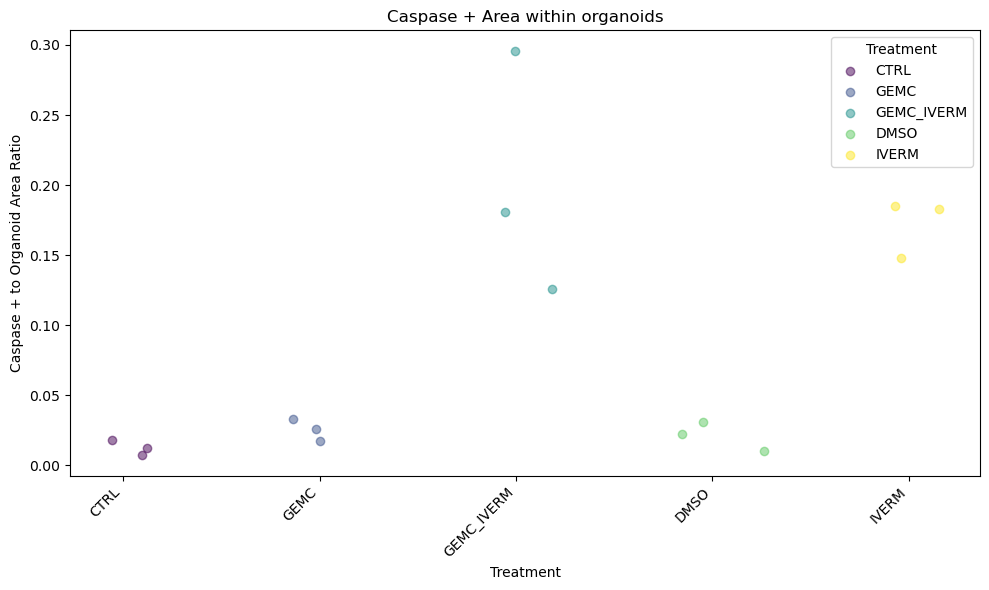

In [125]:
import matplotlib.pyplot as plt

# Get unique treatments
treatments = merged_df['treatment'].unique()

# Assign a color to each treatment using viridis colormap
colors = plt.cm.viridis(np.linspace(0, 1, len(treatments)))
treatment_color_map = dict(zip(treatments, colors))

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot individual data points
for treatment in treatments:
    # Filter data for the current treatment
    data = merged_df[merged_df['treatment'] == treatment]
    
    # Generate x values (treatment indices) with small random jitter to avoid overlapping
    x_values = np.random.normal(loc=np.where(treatments == treatment)[0][0], scale=0.1, size=len(data))
    
    # Plot the points
    ax.scatter(x_values, data['caspase_to_organoid_ratio'], color=treatment_color_map[treatment], label=treatment, alpha=0.5)

# Set the x-axis to show treatment names
ax.set_xticks(range(len(treatments)))
ax.set_xticklabels(treatments, rotation=45, ha='right')

ax.set_xlabel('Treatment')
ax.set_ylabel('Caspase + to Organoid Area Ratio')
ax.set_title('Caspase + Area within organoids')
ax.legend(title='Treatment')

plt.tight_layout()
plt.show()

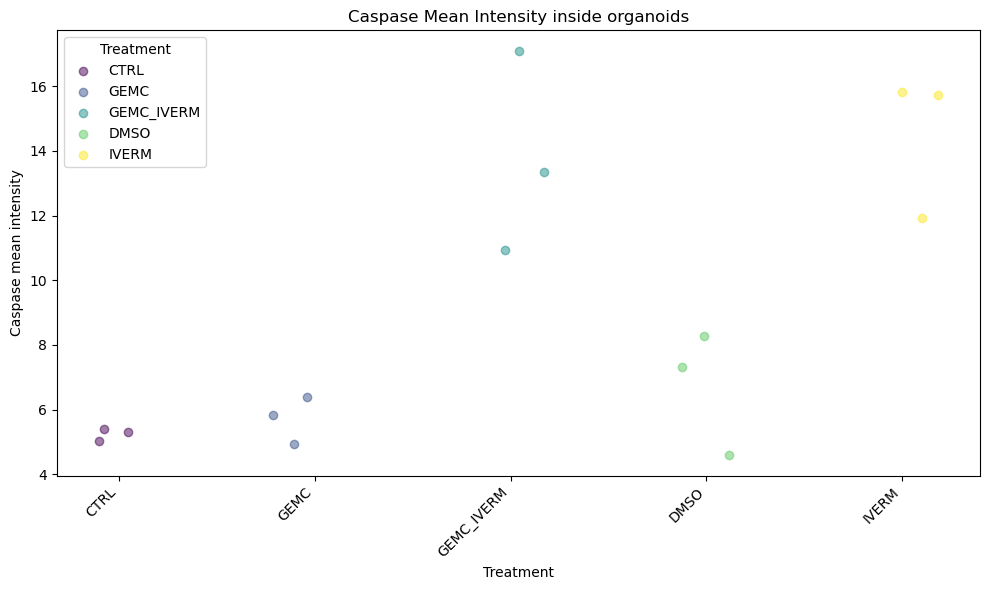

In [126]:
import matplotlib.pyplot as plt

# Get unique treatments
treatments = merged_df['treatment'].unique()

# Assign a color to each treatment using viridis colormap
colors = plt.cm.viridis(np.linspace(0, 1, len(treatments)))
treatment_color_map = dict(zip(treatments, colors))

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot individual data points
for treatment in treatments:
    # Filter data for the current treatment
    data = merged_df[merged_df['treatment'] == treatment]
    
    # Generate x values (treatment indices) with small random jitter to avoid overlapping
    x_values = np.random.normal(loc=np.where(treatments == treatment)[0][0], scale=0.1, size=len(data))
    
    # Plot the points
    ax.scatter(x_values, data['caspase_mean_intensity'], color=treatment_color_map[treatment], label=treatment, alpha=0.5)

# Set the x-axis to show treatment names
ax.set_xticks(range(len(treatments)))
ax.set_xticklabels(treatments, rotation=45, ha='right')

ax.set_xlabel('Treatment')
ax.set_ylabel('Caspase mean intensity')
ax.set_title('Caspase Mean Intensity inside organoids')
ax.legend(title='Treatment')

plt.tight_layout()
plt.show()